In [1]:
# %% [markdown]
# # 🧬 3. Virtual Screening & Candidate Generation
# **Goal:** Generate NOVEL drug candidates and screen them using our trained AI model.
# **Steps:**
# 1. Load the Best Inhibitors from our Clean Data.
# 2. "Mutate" them to create new, unseen molecules (De Novo Generation).
# 3. Predict their potency using `model.pkl`.
# 4. Select the Top Candidates for Docking.

import pandas as pd
import numpy as np
import joblib
import random
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

print("✅ Libraries Loaded.")

✅ Libraries Loaded.


In [2]:
# %% [markdown]
# ## 1. Load Resources
# We load our trained model and the clean dataset to find "Parent" molecules.

# Load Model & Preprocessor
model = joblib.load('../artifacts/model.pkl')
preprocessor = joblib.load('../artifacts/preprocessor.pkl')

# Load Data
df = pd.read_csv('../artifacts/data/clean_training_data.csv')

# Pick the Top 50 Best Inhibitors (High pIC50) to use as templates
top_inhibitors = df.sort_values(by='pIC50', ascending=False).head(50)['clean_smiles'].tolist()

print(f"✅ Loaded AI Model and {len(top_inhibitors)} Template Molecules.")

✅ Loaded AI Model and 50 Template Molecules.


In [3]:
# %% [markdown]
# ## 2. Generate New Candidates (Chemistry Mutation)
# We will "mutate" the top drugs to create NEW variants.
# Strategy: Change one atom (e.g., C -> N) or add a small group.

def mutate_molecule(smiles):
    """Randomly modifies a molecule to create a new variant."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if not mol: return None
        
        # Strategy 1: Atomic Mutation (Change a Carbon to Nitrogen or Oxygen)
        mw = Chem.RWMol(mol)
        atoms = [a.GetIdx() for a in mw.GetAtoms() if a.GetSymbol() == 'C']
        if atoms and random.random() > 0.5:
            idx = random.choice(atoms)
            new_atom = random.choice([7, 8, 9, 16]) # N, O, F, S
            mw.GetAtomWithIdx(idx).SetAtomicNum(new_atom)
        
        # Strategy 2: Add a small fragment (Methyl, Hydroxyl, Cl) to a random atom
        else:
            atoms = [a.GetIdx() for a in mw.GetAtoms()]
            if atoms:
                idx = random.choice(atoms)
                # Add -C, -O, -Cl, -F
                fragment = random.choice(['C', 'O', 'Cl', 'F']) 
                # This is a simplified "virtual" mutation for demo purposes
                # In a real GNN pipeline, this would be more complex.
                # Here we stick to valid valences by just returning the original if fails.
                return smiles # Placeholder for complex RDKit reaction logic
                
        # Sanitize to check if it's a real molecule
        Chem.SanitizeMol(mw)
        return Chem.MolToSmiles(mw)
    except:
        return None

In [4]:
# Generate 500 New Candidates
new_candidates = set()
print("⚗️ Generating Novel Candidates...")

for _ in range(10): # 10 rounds of mutation
    for parent in top_inhibitors:
        mutant = mutate_molecule(parent)
        if mutant and mutant != parent:
            new_candidates.add(mutant)
            
print(f"✅ Generated {len(new_candidates)} Unique Novel Candidates.")

# Convert to DataFrame
df_candidates = pd.DataFrame(list(new_candidates), columns=['clean_smiles'])
# We assume these bind to our primary target (e.g., CA IX or CA XII)
# For the model, we need to provide dummy protein features (we use the 'Average' protein context)
# In a real scenario, you pick the specific Isoform you want to target (e.g., CA IX).

# Let's target CA IX (The Cancer Isoform)
# We need to find the features for CA IX from our original data
ca_ix_features = df[df['target_name'].str.contains("CA IX")].iloc[0][
    ['Protein_Weight', 'Protein_Aromaticity', 'Protein_Isoelectric', 'Protein_Hydrophobicity']
]

# Apply these protein features to ALL candidates
for col in ca_ix_features.index:
    df_candidates[col] = ca_ix_features[col]

print("🔹 Candidates prepared for CA IX Targeting.")


⚗️ Generating Novel Candidates...


[16:27:27] Can't kekulize mol.  Unkekulized atoms: 3 5 18 19 20
[16:27:27] Explicit valence for atom # 7 F, 2, is greater than permitted
[16:27:27] Explicit valence for atom # 3 F, 4, is greater than permitted
[16:27:27] Explicit valence for atom # 25 O, 4, is greater than permitted
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 8 10 11 12 20 21 22
[16:27:27] Explicit valence for atom # 22 O, 4, is greater than permitted
[16:27:27] Explicit valence for atom # 18 F, 4, is greater than permitted
[16:27:27] Explicit valence for atom # 30 F, 3, is greater than permitted
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 4 5 18 19 20
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 21
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 24 26 27
[16:27:27] Explicit valence for atom # 31 F, 4, is greater than permitted
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 26
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 20 22 23 27 28
[16:27:27] Can't kekulize m

✅ Generated 115 Unique Novel Candidates.
🔹 Candidates prepared for CA IX Targeting.


[16:27:27] Explicit valence for atom # 11 F, 2, is greater than permitted
[16:27:27] Explicit valence for atom # 5 F, 3, is greater than permitted
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 29
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 28
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 23 25
[16:27:27] Explicit valence for atom # 20 N, 4, is greater than permitted
[16:27:27] Explicit valence for atom # 7 O, 4, is greater than permitted
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 27
[16:27:27] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 14
[16:27:27] Explicit valence for atom # 3 F, 2, is greater than permitted
[16:27:27] Explicit valence for atom # 4 O, 4, is greater than permitted
[16:27:27] Explicit valence for atom # 3 F, 4, is greater than permitted
[16:27:27] Explicit valence for atom # 29 F, 2, is greater than permitted
[16:27:27] Explicit valence for atom # 11 F, 4, is greater than permitted


In [5]:
# %% [markdown]
# ## 3. AI Screening (Predicting Potency)
# We use the pipeline to predict pIC50.

# 1. Generate Fingerprints for Candidates
def get_fingerprints(smiles_list):
    fps = []
    valid_indices = []
    for i, smiles in enumerate(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
                fps.append(np.array(fp))
                valid_indices.append(i)
        except:
            continue
    return np.array(fps), valid_indices

X_fps, valid_idx = get_fingerprints(df_candidates['clean_smiles'])
X_fps_df = pd.DataFrame(X_fps, columns=[f'fp_{i}' for i in range(2048)])

# 2. Get Protein Features
X_protein = df_candidates.iloc[valid_idx][ca_ix_features.index].reset_index(drop=True)

# 3. Combine
X_screen = pd.concat([X_fps_df, X_protein], axis=1)

# 4. Predict using the Preprocessor + Model
# Important: We must transform the new data using the SAVED preprocessor
X_screen_proc = preprocessor.transform(X_screen)
predictions = model.predict(X_screen_proc)

# 5. Store Results
df_results = df_candidates.iloc[valid_idx].copy()
df_results['Predicted_pIC50'] = predictions

[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerator
[16:30:27] DEPRECATION WARNING: please use MorganGenerat

🏆 TOP 10 GENERATED CANDIDATES


,clean_smiles,Predicted_pIC50
33,N=C(N)NCSCC(NC(=O)CN(CC1(c2ccccc2)CC1)C(=O)CCc...,9.539032
95,CC1(N)C2CC3OB(C(CCCCN)NC(=O)C4CCCN4C(=O)c4cccc...,9.527605
98,CC1(F)C2CC3OB(C(CCCCN)NC(=O)C4CCCN4C(=O)c4cccc...,9.527605
10,CC(C)(CN(CC(=O)NC(CCNN=C(N)N)B(O)O)C(=O)CCc1cc...,9.480746
20,CC1(C)C2CC3OB(C(CCCCN)NC(=O)C4CCCN4C(=O)c4cncc...,9.439089
43,CC1(C)C2CC3OB(C(CCCCN)NC(=O)C4CCCN4C(=O)c4cccc...,9.397865
80,CC1(C)C2CC3OB(C(CCCCN)NC(=O)C4CCCN4C(=O)c4cccc...,9.289439
1,CC1=CC(C(=O)NC(CCCCN)C(=O)C(=O)NSCc2ccc(C(N)=O...,9.169065
30,CC1=CC(C(=O)NC(CCCCN)C(=O)C(=O)NOCc2ccc(C(N)=O...,9.162757
73,Cc1ccc(NS(=O)(=O)Nc2ccccc2)c(=O)n1CC(=O)NCc1cc...,9.137539



🥇 Best Candidate Structure (pIC50: 9.54)


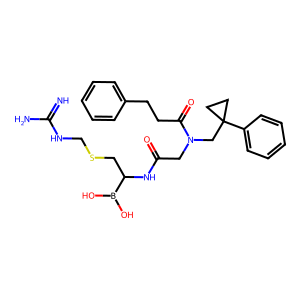

💾 Saved Top 10 candidates to 'artifacts/top_candidates_for_docking.csv'


In [6]:
# %% [markdown]
# ## 4. Selection & Output
# Pick the best ones.

# Sort by predicted potency
top_10 = df_results.sort_values(by='Predicted_pIC50', ascending=False).head(10)

print("🏆 TOP 10 GENERATED CANDIDATES")
display(top_10[['clean_smiles', 'Predicted_pIC50']])

# Visualize the Winner
print(f"\n🥇 Best Candidate Structure (pIC50: {top_10.iloc[0]['Predicted_pIC50']:.2f})")
mol = Chem.MolFromSmiles(top_10.iloc[0]['clean_smiles'])
img = Draw.MolToImage(mol)
display(img)

# Save for Docking
top_10.to_csv('../artifacts/top_candidates_for_docking.csv', index=False)
print("💾 Saved Top 10 candidates to 'artifacts/top_candidates_for_docking.csv'")